In [1]:
import os
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [2]:
reg_expressions={
    'Emojis':r'[\U0001f600-\U0001f650]',
    'hashtags':r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",
    'Mentions':r'(?:@[\w_]+)',
    'URLs':r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',
    'RTs':r"(RT|via)((?:\b\W*@\w+)+)"
}

In [3]:
labels={}
df={}
tag_df={}
for tipo in ['training','test']:
    tweets={}
    labels[tipo]={}
    for doc in os.listdir(tipo):
        if 'xml' in doc:
            with open(tipo+'/'+doc,'r') as xml_doc:
                tweets[doc.strip('.xml')]=' '.join([tweet.replace(']]></document>','') \
                                   for tweet in xml_doc.read().split('<document><![CDATA[')[1:]])\
                .replace('\n\t\t',' || ')
        else:
            with open(tipo+'/'+doc,'r') as txt_doc:
                labels[tipo]=pd.read_csv(txt_doc,sep=':::',header=None,names=['sexo','pais'],engine='python')
    
    
    df[tipo]=pd.DataFrame(list(tweets.values()),index=list(tweets.keys()),columns=['tweets'])
    

    
    tag_df[tipo]={}
    for (key,reg_ex) in reg_expressions.items():
        aux_list=[]
        for index,row in df[tipo].iterrows():
            cuenta=re.findall(reg_ex, row['tweets'])
            cuenta = len(cuenta)
            aux_list.append(cuenta)
        aux_list=np.array(aux_list)
        tag_df[tipo][key]=aux_list
    tag_df[tipo] = pd.DataFrame(tag_df[tipo],index=df[tipo].index)
    labels[tipo]=df[tipo].join(labels[tipo],how='inner')[['sexo','pais']]
    
    max_len=df['training']['tweets'].str.len().max()
    tag_df[tipo]['longitud']=df[tipo]['tweets'].str.len()/max_len
    print(df[tipo].shape,tag_df[tipo].shape,labels[tipo].shape)

(2800, 1) (2800, 6) (2800, 2)
(1400, 1) (1400, 6) (1400, 2)


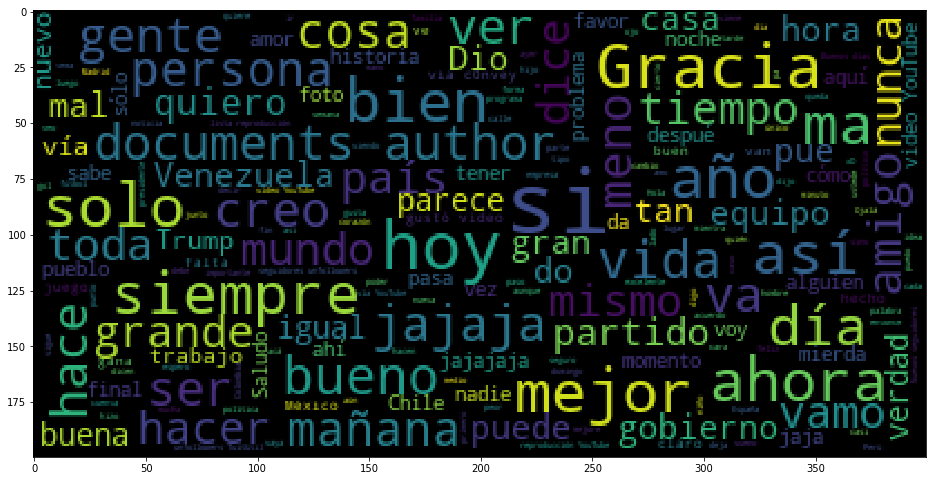

male :
 Emojis      12.245714
hashtags    25.573571
Mentions    73.790357
URLs        41.506786
RTs          1.118571
longitud     0.666084
dtype: float64 



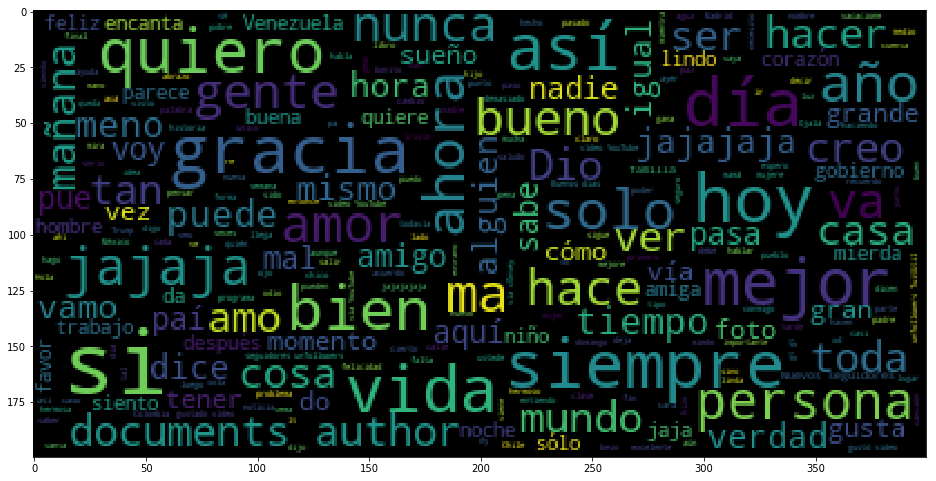

female :
 Emojis      27.532857
hashtags    26.440357
Mentions    62.311071
URLs        37.919286
RTs          0.783571
longitud     0.611633
dtype: float64 



In [4]:
tag_df_sex={}
for sexo in ['male','female']:
    text=df['training'].loc[labels['training']['sexo']==sexo,'tweets'].str.cat()
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="black", max_words=10000,\
                   stopwords=stopwords.words('spanish')+['http','https','co'], max_font_size= 40)
    wc.generate(text)
    plt.imshow(wc)
    plt.show()
    tag_df_sex[sexo]=pd.concat([tag_df['training'].loc[labels['training']['sexo']==sexo,:].mean(),\
                                tag_df['test'].loc[labels['test']['sexo']==sexo,:].mean()],axis=1).mean(axis=1) 
    print(sexo,':\n',tag_df_sex[sexo],'\n')

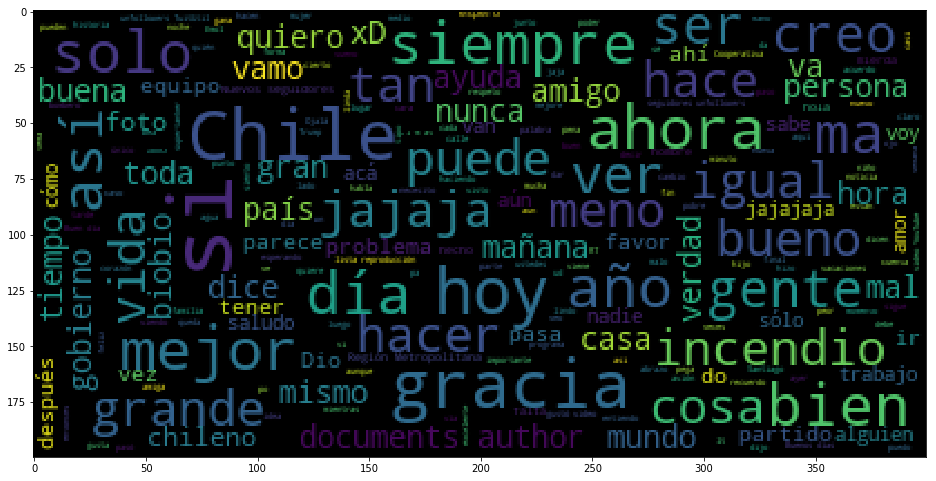

chile :
 Emojis      18.753750
hashtags    28.263750
Mentions    72.977500
URLs        35.403750
RTs          0.768750
longitud     0.641618
dtype: float64 



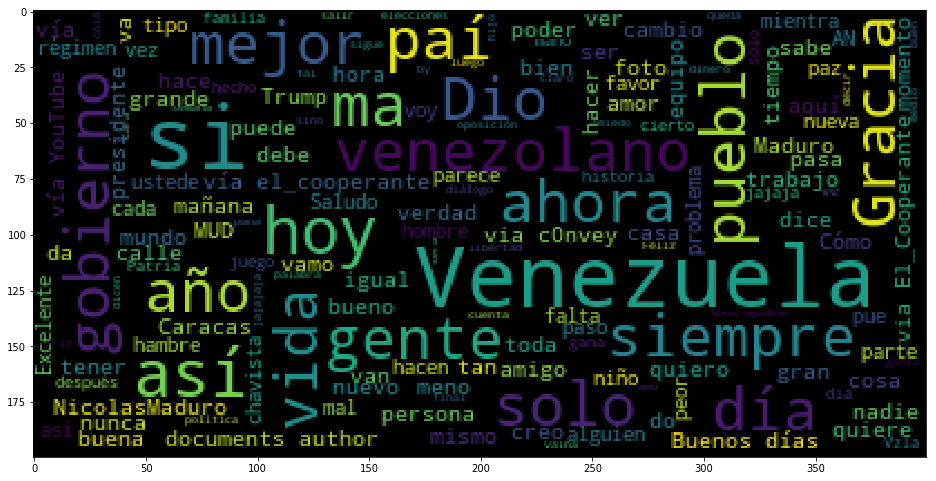

venezuela :
 Emojis       4.757500
hashtags    27.551250
Mentions    67.102500
URLs        48.678750
RTs          2.792500
longitud     0.702906
dtype: float64 



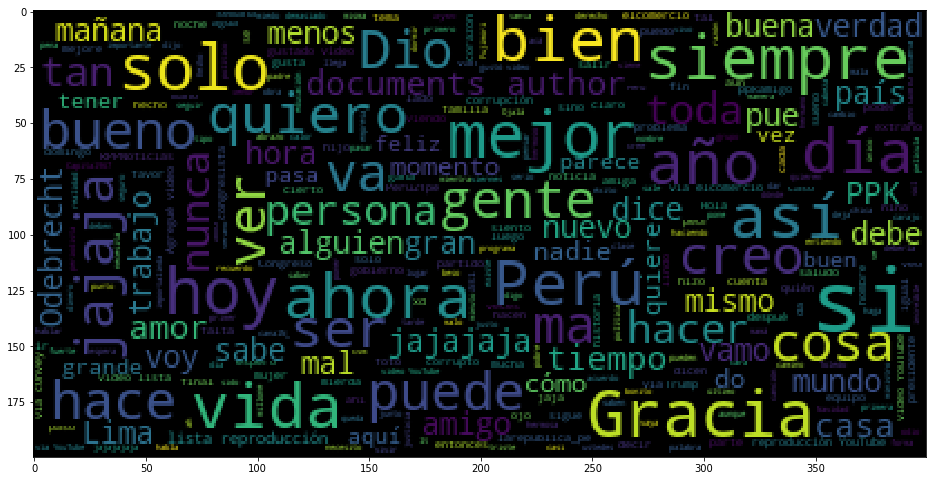

peru :
 Emojis      24.821250
hashtags    23.731250
Mentions    65.630000
URLs        38.721250
RTs          0.458750
longitud     0.632717
dtype: float64 



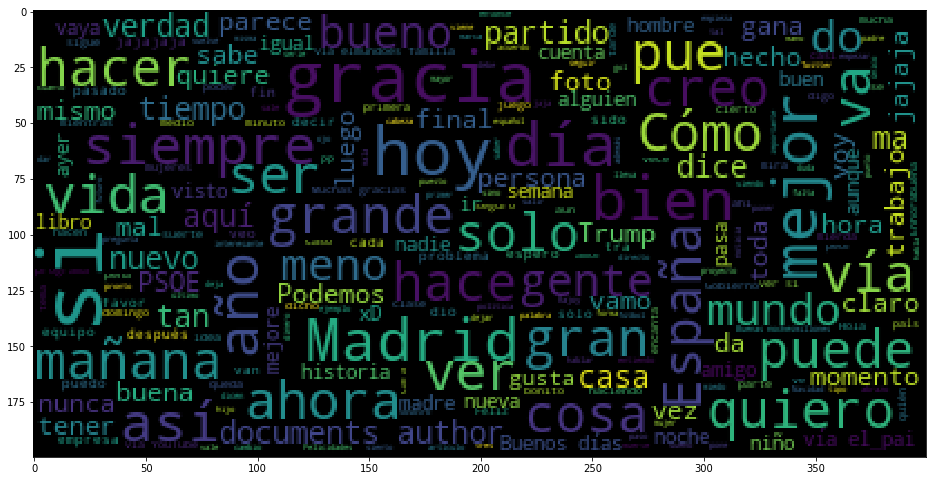

spain :
 Emojis      21.398750
hashtags    31.010000
Mentions    79.577500
URLs        47.763750
RTs          0.760000
longitud     0.674259
dtype: float64 



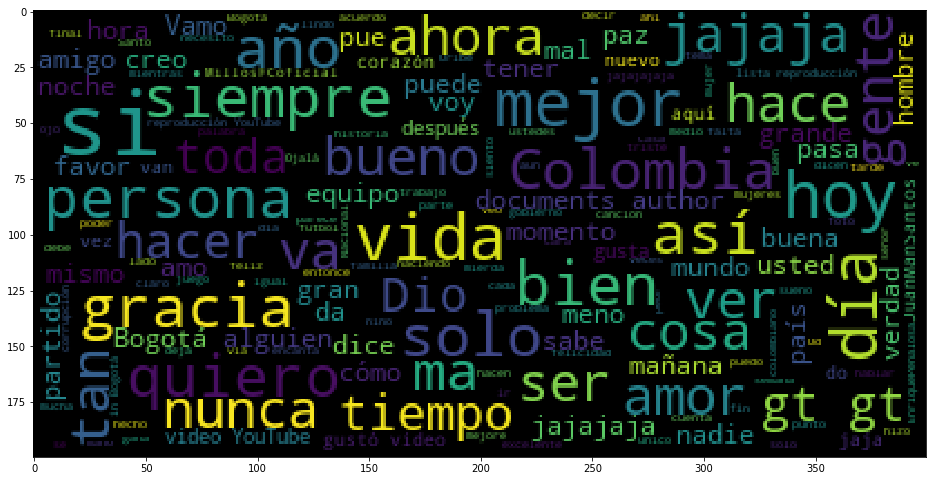

colombia :
 Emojis      22.218750
hashtags    20.487500
Mentions    65.093750
URLs        32.512500
RTs          0.717500
longitud     0.617075
dtype: float64 



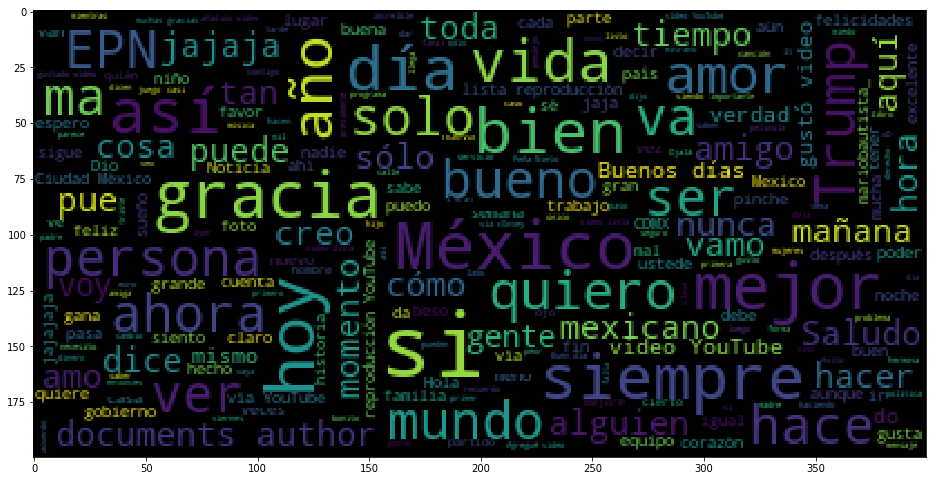

mexico :
 Emojis      25.612500
hashtags    34.196250
Mentions    71.040000
URLs        47.806250
RTs          0.570000
longitud     0.647087
dtype: float64 



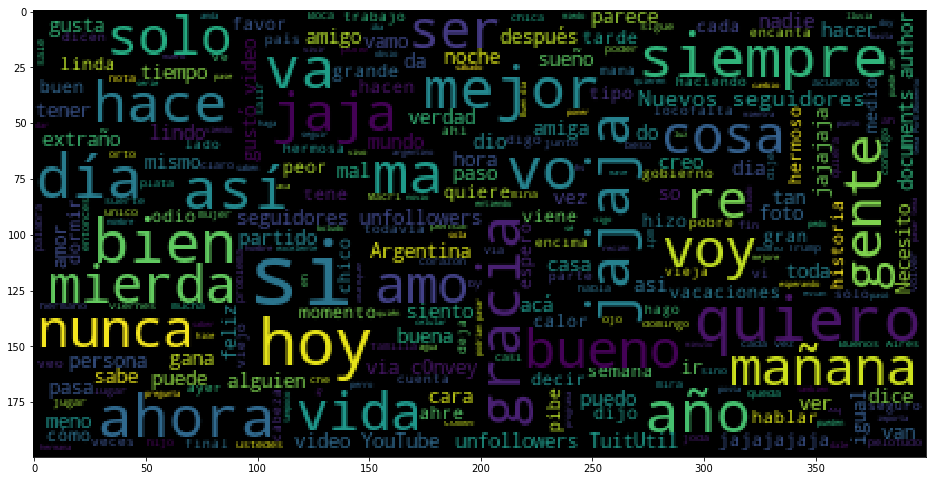

argentina :
 Emojis      21.662500
hashtags    16.808750
Mentions    54.933750
URLs        27.105000
RTs          0.590000
longitud     0.556347
dtype: float64 



In [5]:
tag_df_pais={}
for pais in labels['training']['pais'].value_counts().index:
    text=df['training'].loc[labels['training']['pais']==pais,'tweets'].str.cat()
    
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="black", max_words=10000,\
                   stopwords=stopwords.words('spanish')+['http','https','co'], max_font_size= 40)
    wc.generate(text)
    plt.imshow(wc)
    plt.show()
    
    tag_df_pais[pais]=pd.concat([tag_df['training'].loc[labels['training']['pais']==pais,:].mean(),\
                                tag_df['test'].loc[labels['test']['pais']==pais,:].mean()],axis=1).mean(axis=1) 
    print(pais,':\n',tag_df_pais[pais],'\n')

In [6]:
tag_df_max=pd.concat([tag_df['training'].max(),tag_df['test'].max()],axis=1).max(axis=1)
tag_df['training']/=tag_df_max
tag_df['test']/=tag_df_max

In [7]:
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

models=[
    MultinomialNB(),
    LinearSVC(),
    RandomForestClassifier(100,max_depth=25)
]

In [8]:
y_train={}
y_test={}
X_train={}
X_test={}
vectorizers={
    'sexo':TfidfVectorizer(analyzer="word", stop_words=stopwords.words('spanish'),\
                           ngram_range=(1,2), max_df=0.9,max_features=10000),
    'pais':TfidfVectorizer(analyzer="word",\
                           ngram_range=(1,2),max_features=20000)
}

for label in ['sexo','pais']:
    y_train[label]=labels['training'][label].values
    y_test[label]=labels['test'][label].values

    tfidfv=vectorizers[label]

    X_train[label]=tfidfv.fit_transform(df['training']['tweets'].values)
    X_test[label]=tfidfv.transform(df['test']['tweets'].values)

    X_train[label] = np.hstack([X_train[label].toarray(),tag_df['training'].values])
    X_test[label] = np.hstack([X_test[label].toarray(),tag_df['test'].values])
 

In [9]:
predicted={}
for model in models:
    print(str(model.__class__).split('.')[-1].split("'")[0],':')
    for label in ['sexo','pais']:
        model.fit(X_train[label],y_train[label].ravel())
        predicted[label]=(y_test[label].ravel()==model.predict(X_test[label]))
        print('\t',label,': ',predicted[label].mean())
        
    print('\t Joint: ',(predicted['sexo']*predicted['pais']).mean())

MultinomialNB :
	 sexo :  0.6871428571428572
	 pais :  0.7971428571428572
	 Joint:  0.5342857142857143
LinearSVC :
	 sexo :  0.76
	 pais :  0.9342857142857143
	 Joint:  0.7085714285714285
RandomForestClassifier :
	 sexo :  0.7257142857142858
	 pais :  0.9292857142857143
	 Joint:  0.6721428571428572
